# 5. K-Means Clustering with the Retail Data-Set #
Demonstration of using the [Spark MLlib](https://spark.apache.org/docs/latest/ml-guide.html) machine learning library to apply the K-Means algorithm to the Retail data-set.  The retail data-set can be downloaded using notebook 1 "*pyspark-nb-1.ipynb*"  

"*The MLlib RDD-based API is now in maintenance mode.
As of Spark 2.0, the RDD-based APIs in the spark.mllib package have entered maintenance mode. The primary Machine Learning API for Spark is now the DataFrame-based API in the spark.ml package.*"

Steps covered in this notebook:  
- Split the data into a test and training dataset using the Spark DF `randomSplit` function  
- Use MLlib `StringIndexer` and `OneHotEncoder` to encode the Day-of-Week as numeric data  
- Combine feature columns into a single Vector stored in one column using the MLlib `VectorAssembler`  
- Use MLlib `Pipeline` to link multiple stages into a single pipeline of data processing transformation  
- Use MLlib `KMeans` to build a clustering model that classifies data into clusters.  

Cluster Model Training and Evaluation  
- Evaluate best number of clusters to choose using the `evaluation.ClusteringEvaluator` library  
- Consider the distance from centers (optimize at minimum for least error)  and the [cluster Silhouette](https://en.wikipedia.org/wiki/Silhouette_(clustering)) value (optimize at +1)

Cluster Model Testing
- try classifying test data with the KMeans model and examine the cluster classification results  




In [1]:
# Connect to Spark Server
from pyspark.sql import SparkSession
spark = SparkSession.\
        builder.\
        appName("pyspark-nb-5-kmeans").\
        master("spark://spark-master:7077").\
        config("spark.executor.memory", "512m").\
        config("spark.eventLog.enabled", "true").\
        config("spark.eventLog.dir", "file:///opt/workspace/events").\
        getOrCreate() 

22/03/04 17:20:27 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


In [2]:
# Only log errors at ERROR, skip INFO  and WARN
spark.sparkContext.setLogLevel("ERROR")

#### Load Data ####

In [3]:
# import date_format fuction and col ("return a column") function
from pyspark.sql.functions import date_format, col

In [4]:
# Load data
retailDataFrame = spark.read.option("inferSchema", True).option("header", True).csv("/opt/workspace/datain/retail-data/by-day/*.csv")

In [5]:
# Fill Na's and create a day_of_week column.   coalesce(2) function coalesce's data down to 2 node partitions
preppedDataFrame = retailDataFrame.na.fill(0).withColumn("day_of_week", date_format(col("InvoiceDate"), "EEEE")).coalesce(2)

#### Explore the Data ####
Very brief look at the data-set.

In [6]:
preppedDataFrame.show(5)

+---------+---------+--------------------+--------+-------------------+---------+----------+--------------+-----------+
|InvoiceNo|StockCode|         Description|Quantity|        InvoiceDate|UnitPrice|CustomerID|       Country|day_of_week|
+---------+---------+--------------------+--------+-------------------+---------+----------+--------------+-----------+
|   580538|    23084|  RABBIT NIGHT LIGHT|      48|2011-12-05 08:38:00|     1.79|   14075.0|United Kingdom|     Monday|
|   580538|    23077| DOUGHNUT LIP GLOSS |      20|2011-12-05 08:38:00|     1.25|   14075.0|United Kingdom|     Monday|
|   580538|    22906|12 MESSAGE CARDS ...|      24|2011-12-05 08:38:00|     1.65|   14075.0|United Kingdom|     Monday|
|   580538|    21914|BLUE HARMONICA IN...|      24|2011-12-05 08:38:00|     1.25|   14075.0|United Kingdom|     Monday|
|   580538|    22467|   GUMBALL COAT RACK|       6|2011-12-05 08:38:00|     2.55|   14075.0|United Kingdom|     Monday|
+---------+---------+-------------------

In [7]:
#Summary stats
preppedDataFrame.describe().show()

[Stage 5:=============================>                             (1 + 1) / 2]

+-------+------------------+------------------+--------------------+------------------+------------------+------------------+-----------+-----------+
|summary|         InvoiceNo|         StockCode|         Description|          Quantity|         UnitPrice|        CustomerID|    Country|day_of_week|
+-------+------------------+------------------+--------------------+------------------+------------------+------------------+-----------+-----------+
|  count|            541909|            541909|              540455|            541909|            541909|            541909|     541909|     541909|
|   mean|  559965.752026781|27623.240210938104|             20713.0|  9.55224954743324|4.6111136260826315|11476.974671024102|       null|       null|
| stddev|13428.417280792186|16799.737628427614|                 NaN|218.08115785023375| 96.75985306117823|  6777.90832601304|       null|       null|
|    min|            536365|             10002| 4 PURPLE FLOCK D...|            -80995|         -110

In [8]:
# Distribution of records by country
from pyspark.sql.functions import desc
preppedDataFrame.groupby('Country').count().sort(desc("count")).show(100,False)

[Stage 8:==============================>                        (112 + 2) / 200]

+--------------------+------+
|Country             |count |
+--------------------+------+
|United Kingdom      |495478|
|Germany             |9495  |
|France              |8557  |
|EIRE                |8196  |
|Spain               |2533  |
|Netherlands         |2371  |
|Belgium             |2069  |
|Switzerland         |2002  |
|Portugal            |1519  |
|Australia           |1259  |
|Norway              |1086  |
|Italy               |803   |
|Channel Islands     |758   |
|Finland             |695   |
|Cyprus              |622   |
|Sweden              |462   |
|Unspecified         |446   |
|Austria             |401   |
|Denmark             |389   |
|Japan               |358   |
|Poland              |341   |
|Israel              |297   |
|USA                 |291   |
|Hong Kong           |288   |
|Singapore           |229   |
|Iceland             |182   |
|Canada              |151   |
|Greece              |146   |
|Malta               |127   |
|United Arab Emirates|68    |
|European 

-> The data is heavily skewed to the UK.

In [9]:
# Distinct number of product codes 
preppedDataFrame.select('StockCode').distinct().count()

4070

-> There are 4070 distinct products

#### Split Data into Test and Training Sets ####
Splitting data into test and training sets is not always necessarily required for unsupervised cluster analysis.  However, we want to analyse the cluster separation ("silhouette") and error we get with a new data set based on a training set to determine best number of clusters to choose.

In [10]:
# split the data 80 /20
trainDataFrame, testDataFrame = preppedDataFrame.randomSplit([0.8, 0.2], seed = 42)
print("Training Data Rows: {}, Test Data Rows: {}".format(str(trainDataFrame.count()), str(testDataFrame.count())) )

[Stage 14:=============================>                            (1 + 1) / 2]

Training Data Rows: 434243, Test Data Rows: 107666


#### Use `StringIndexer` and `OneHotEncoder` to Encode Day-of-Week and create a Feature `VectorAssembler` ####
Ref: https://spark.apache.org/docs/latest/ml-features

In [11]:
from pyspark.ml.feature import StringIndexer # takes range of string labels and maps to integer values
from pyspark.ml.feature import OneHotEncoder # One-hot-encoding for categorical features; encode as binary encoded vector-col

In [12]:
indexer = StringIndexer().setInputCol("day_of_week").setOutputCol("day_of_week_index")
encoder = OneHotEncoder().setInputCol("day_of_week_index").setOutputCol("day_of_week_encoded")

Assemble multi-value vector of features including one-hot representation for day-of-week into a vector stored in a single column.  
For this example only three features are chosen for the model:  
+ UnitPrice
+ Quantity  
+ Day_of_Week

In [13]:
from pyspark.ml.feature import VectorAssembler
vectorAssembler = VectorAssembler().setInputCols(["UnitPrice", "Quantity", "day_of_week_encoded"]).setOutputCol("features")

#### Create a Model Training Pipeline ####
  
Train a K-Means cluster model with *Day-of-Week* and *Unit Price* and *Quantity* in the feature-set

First, fit the transformers to the data-set.  The `StringIndexer` needs to know how many unique values there are to index.  

In [14]:
from pyspark.ml import Pipeline
transformationPipeline = Pipeline().setStages([indexer, encoder, vectorAssembler])
fittedPipeline = transformationPipeline.fit(trainDataFrame)
transformedTraining = fittedPipeline.transform(trainDataFrame)
transformedTest = fittedPipeline.transform(testDataFrame)

It would be possible to also include the model training in the pipeline above.  Instead we next *cache* the pipeline and then experiment with different hyperparameters training a model against the same pipeline.

In [15]:
transformedTraining.cache()

DataFrame[InvoiceNo: string, StockCode: string, Description: string, Quantity: int, InvoiceDate: timestamp, UnitPrice: double, CustomerID: double, Country: string, day_of_week: string, day_of_week_index: double, day_of_week_encoded: vector, features: vector]

### Import KMeans from `pyspark.ml.clustering` and Fit a Model ##
https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.clustering.KMeans.html#pyspark.ml.clustering.KMeans.k

In [16]:
# Import the Spark ML Kmeans model
from pyspark.ml.clustering import KMeans

# Evaluate clustering by computing Silhouette score
from pyspark.ml.evaluation import ClusteringEvaluator
evaluator = ClusteringEvaluator()

# set K - the number of clusters to create
#kmeans = KMeans().setK(8).setSeed(42)
#kmModel = kmeans.fit(transformedTraining)

#### Look for Optimal Number of Clusters ####
Consider **Cluster Separation** and **Standard Error** cost to evaluate different numbers of clusters to choose.  
  
The Standard Error measure of distance from the cluster center can be used to try to make sure there enough clusters and the Silhouette score can be used to measure how effectively individual data-points are clearly separated into a specific cluster (not too many clusters).  
  
This can take several minutes to run. *Skip this step and just choose K=8 clusters to avoid the analysis phase* by skipping ahead to the "*Identify Clusters in the Test Data-Set*" section below.

Get std-err for clusters K=2


Get std-err for clusters K=3


Get std-err for clusters K=4
Get std-err for clusters K=5
Get std-err for clusters K=6
Get std-err for clusters K=7
Get std-err for clusters K=8
Get std-err for clusters K=9
Get std-err for clusters K=10
Get std-err for clusters K=11
Get std-err for clusters K=12
Get std-err for clusters K=13
Get std-err for clusters K=14
Get std-err for clusters K=15


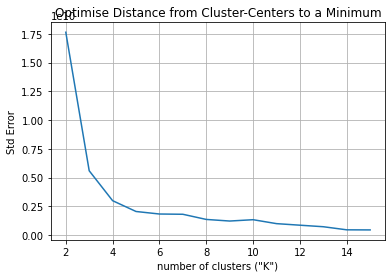

In [17]:
# Look for optimal K number of clusters from 2 to 15
costs = []
# range 2 to 15 _inclusive_
for K in range(2,16):
    print("Get std-err for clusters K={}".format(K))
    kmModel = KMeans().setK(K).setSeed(42).fit(transformedTraining)    
    costs.append(kmModel.computeCost(transformedTraining))    

# Plot the results
import matplotlib.pyplot as plt
plt.plot(range(2,16), costs)
plt.xlabel("number of clusters (\"K\")")
plt.ylabel("Std Error")
plt.title("Optimise Distance from Cluster-Centers to a Minimum")
plt.grid(True)

To avoid an issue with calculating the Silhoutte score for small numbers of cluster - "*assertion failed: Number of clusters must be greater than one*", start the range of clusters to test at 4.

Get silhouette cluster-fit for clusters K=4


Get silhouette cluster-fit for clusters K=5


Get silhouette cluster-fit for clusters K=6


Get silhouette cluster-fit for clusters K=7


Get silhouette cluster-fit for clusters K=8


Get silhouette cluster-fit for clusters K=9


Get silhouette cluster-fit for clusters K=10


Get silhouette cluster-fit for clusters K=11


Get silhouette cluster-fit for clusters K=12


Get silhouette cluster-fit for clusters K=13


Get silhouette cluster-fit for clusters K=14


Get silhouette cluster-fit for clusters K=15


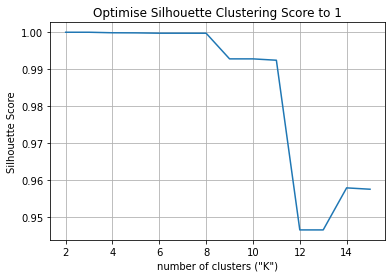

In [18]:
# Look for optimal K number of clusters from 
silhouettes = [1,1] # pad the array as can't run this for 2,3 clusters due to "Number of clusters must be greater than one" error
for K in range(4,16):
    print("Get silhouette cluster-fit for clusters K={}".format(K))
    kmModel = KMeans().setK(K).setSeed(42).fit(transformedTraining)    
    # predict clusters with test data-set and determine level of separatation between clusters (1 is optimal)
    predictions = kmModel.transform(transformedTest)
    silhouette = evaluator.evaluate(predictions)
    #print("Silhouette with squared euclidean distance = " + str(silhouette))
    silhouettes.append(silhouette)   
    
# Plot the results
import matplotlib.pyplot as plt
plt.plot(range(2,16), silhouettes)
plt.xlabel("number of clusters (\"K\")")
plt.ylabel("Silhouette Score")
plt.title("Optimise Silhouette Clustering Score to 1")
plt.grid(True)

Based on the above outcomes for Std-Err and Silhouette score, a value of between 8 and 11 clusters would be appropriate.  For the rest of this notebook, choose **8 clusters** for maximum cluster separation and lower std error (overall distance from cluster center).

#### Identify Clusters in the Test data-set ####
Working with the test data-set, generate preditions from the model

In [19]:
kmModel = KMeans().setK(8).setSeed(42).fit(transformedTraining)    
predictions = kmModel.transform(transformedTest)

In [20]:
# Evaluate clustering by computing Silhouette score
evaluator = ClusteringEvaluator()
silhouette = evaluator.evaluate(predictions)
print("Silhouette with squared euclidean distance = " + str(silhouette))

[Stage 798:============================>                            (1 + 1) / 2]

Silhouette with squared euclidean distance = 0.9997311944922104


## Analysis of Test Data using the Cluster Model ##

Analysis of the test data, making comparisons of data that is classified in different clusters by the trained model.
  
The predicted cluster-ID is provided in the `prediction` column.


In [21]:
predictions.select("Description", "Country", "day_of_week", "UnitPrice", "Quantity", "prediction").show(10)

[Stage 800:>                                                        (0 + 1) / 1]

+--------------------+--------------+-----------+---------+--------+----------+
|         Description|       Country|day_of_week|UnitPrice|Quantity|prediction|
+--------------------+--------------+-----------+---------+--------+----------+
|SET 7 BABUSHKA NE...|United Kingdom|  Wednesday|     7.65|       2|         0|
| WHITE METAL LANTERN|United Kingdom|  Wednesday|     3.39|       6|         0|
|RED WOOLLY HOTTIE...|United Kingdom|  Wednesday|     3.39|       6|         0|
|BOX OF VINTAGE AL...|United Kingdom|  Wednesday|     9.95|       2|         0|
|POPPY'S PLAYHOUSE...|United Kingdom|  Wednesday|      2.1|       6|         0|
|MINI JIGSAW CIRCU...|        France|  Wednesday|     0.42|      24|         0|
|VINTAGE BILLBOARD...|United Kingdom|  Wednesday|     1.06|       6|         0|
|VINTAGE BILLBOARD...|United Kingdom|  Wednesday|     1.06|       6|         0|
| SAVE THE PLANET MUG|United Kingdom|  Wednesday|     1.06|       6|         0|
|WOOD S/3 CABINET ...|United Kingdom|  W

Other class-labels not used in the feature-set
1. StockCode (same as Description?)  
2. CustomerID  
3. Country  


#### Check: How many distinct clusters do the Countries belong to? ####

In [22]:
#Pandas version
#pandas_df = predictions.select("StockCode","CustomerID", "Country", "prediction").toPandas()
#pandas_df.groupby('Country')['prediction'].nunique()

#Spark Version
import pyspark.sql.functions as f
#predictions.groupby('Country').agg(f.expr('count(distinct prediction)').alias('n_clusters')).show(100,False)
predictions.groupby('prediction', 'Country').agg(f.expr('count(distinct prediction)').alias('n_clusters')).sort("Country", "prediction").show(100,False)

[Stage 801:============================>                            (1 + 1) / 2]

+----------+--------------------+----------+
|prediction|Country             |n_clusters|
+----------+--------------------+----------+
|0         |Australia           |1         |
|0         |Austria             |1         |
|0         |Bahrain             |1         |
|0         |Belgium             |1         |
|0         |Brazil              |1         |
|0         |Canada              |1         |
|0         |Channel Islands     |1         |
|0         |Cyprus              |1         |
|0         |Czech Republic      |1         |
|0         |Denmark             |1         |
|0         |EIRE                |1         |
|0         |European Community  |1         |
|0         |Finland             |1         |
|0         |France              |1         |
|0         |Germany             |1         |
|0         |Greece              |1         |
|0         |Hong Kong           |1         |
|0         |Iceland             |1         |
|0         |Israel              |1         |
|0        

-> All the countries except the UK are only in one or two clusters.  If the data-set wasn't so heavily skewed to UK data, this might be interesting.
  
**Conclusion** - the results of this analysis are skewed by the fact most of the data is related to the UK anyway.

#### Check: How many items in each cluster? ####

In [23]:
#### how many items per cluster? ####
predictions.groupby('prediction').count().show()

+----------+------+
|prediction| count|
+----------+------+
|         6|     5|
|         3|     1|
|         7|     4|
|         0|107656|
+----------+------+



-> Most of the data is in Cluster 0.  

**Conclusion** - any items not in *Cluster 0* are outliers in terms of the Price, Quantity and Day-of-Week features.

#### Programatically get the cluster-IDs for outliers ####

In [ ]:
# programaticaly Get the cluster-ids where count is less than 50, look at those items
# To filter on the count, need to rename the count column: https://stackoverflow.com/questions/32119936/dataframe-how-to-groupby-count-then-filter-on-count-in-scala
outliers = predictions.groupBy('prediction').count()\
   .withColumnRenamed("count", "n")\
   .filter("n <= 50")\
   .sort("n").select("prediction")

outliers_list = outliers.select("prediction").rdd.flatMap(lambda x: x).collect()
print("Outliers", outliers_list)
#for cluster in outliers_list:
#    predictions.where("prediction = $cluster")

In [ ]:
#retailOutliers = predictions.isin(outliers_list)
retailOutliers = predictions.filter(col("prediction").isin(outliers_list))

#### Visual Inspection of the Outliers Data ####

In [ ]:
retailOutliers.select("InvoiceNo", "Country", "StockCode", "Description", "Quantity", "UnitPrice", "day_of_week", "prediction").show()

**Check** Why is the StockCode=M in Singapore an Outlier?  
View all the original test data and see if there are other StockCode = "M" records.

In [ ]:
# examine data-points in the test data set where Stock Code = "M"
transformedTest.filter((col("StockCode") == 'M') & (col("Country") == 'Singapore')).show()

-> There are two other Manual transactions in Singapore, but these are for smaller amounts.

**Check** do we have negative quantities with Unit Price = Zero in the test data set in cluster Zero (non outliers)?

In [ ]:
transformedTest.filter((col("UnitPrice") == 0) & (col("Quantity") < 0)).show()

-> Other refunds exist, but for smaller amounts

**Conclusion** The KMeans cluster is identifying unusual transactions, these tend to be refunds or unusually high Unit Price values.

In [ ]:
spark.stop()